In [ ]:
# 全体を通じてよく使うパッケージ

import numpy as np
import matplotlib.pyplot as plt
import copy

In [ ]:
# 長い処理が終わった時にビープ音を鳴らすようにすると便利（Colabのみ）

from google.colab import output

def beep():
    output.eval_js('new Audio("https://soundeffect-lab.info/sound/anime/mp3/kotsudumi1.mp3").play()')

# FSDD
Free spoken digit datasetという音声のデータセットをダウンロードして前処理

In [ ]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4243, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 4243 (delta 16), reused 8 (delta 8), pack-reused 4212
Receiving objects: 100% (4243/4243), 30.38 MiB | 21.97 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [ ]:
from scipy.io.wavfile import read
import os

# root_pathはcloneしたリポジトリのパス（適宜変更）
root_path = '/content/free-spoken-digit-dataset/recordings'
filenames = os.listdir(root_path)

person_list = ['jackson', 'nicolas', 'theo', 'yweweler', 'george', 'lucas']

x_train = []
x_test = []
t_digit_train = []
t_digit_test = []
t_person_train = []
t_person_test = []

for filename in filenames:
    # ファイル名が0_george_0.wavのようになっているので
    # ファイル名から，0 (digit label), george (person label), 0 (data id)を取得
    digit, person, id = filename.split('.')[0].split('_')

    # ファイル読み込み
    sr, data = read(os.path.join(root_path, filename))

    # data idが0-4はtest用
    if int(id) < 5:
        x_test.append(data)
        t_digit_test.append(int(digit))
        t_person_test.append(person_list.index(person))

    # data idが5-49はtrain用
    else:
        x_train.append(data)
        t_digit_train.append(int(digit))
        t_person_train.append(person_list.index(person))

In [ ]:
# 8000 time step（1s）以降は声が入っていないので
# 全てのデータを8000 time stepで揃える
LENGTH = 8000

x_train_array = []
for x in x_train:
    zero = np.zeros((1, LENGTH), dtype=np.float32)
    zero[0, :x.shape[0]] = x[:LENGTH]
    x_train_array.append(zero)

x_test_array = []
for x in x_test:
    zero = np.zeros((1, LENGTH), dtype=np.float32)
    zero[0, :x.shape[0]] = x[:LENGTH]
    x_test_array.append(zero)

x_train_array = np.concatenate(x_train_array, axis=0)
x_test_array = np.concatenate(x_test_array, axis=0)

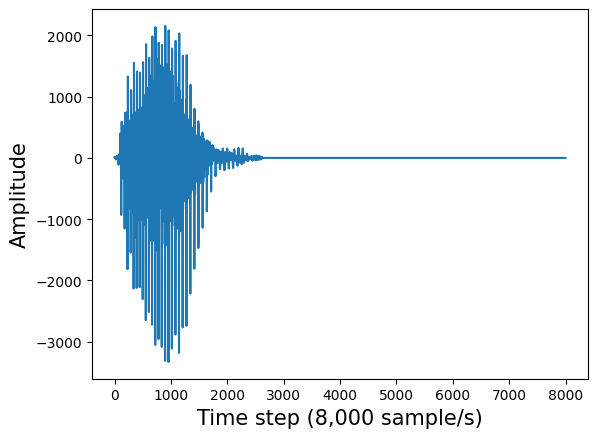

In [ ]:
# 波形表示

plt.rcParams["font.size"] = 15
plt.plot(x_train_array[0])
plt.xlabel('Time step (8,000 sample/s)')
plt.ylabel('Amplitude')
plt.tick_params(labelsize=10)
plt.show()

# FSDD + Lyon
ダウンロードしたFSDDをLyon's auditory modelで前処理してコクリアグラムを得る

In [ ]:
!pip install lyon

In [ ]:
import lyon.calc
calc = lyon.calc.LyonCalc()

In [ ]:
x_train_lyon = []
for x in x_train_array:
    x = x.astype(np.float64)

    # x：音声信号
    # sr：xのサンプリングレート．ここでは8000Hz
    # decimation_factor：間引き処理のパラメータ．time stepが 1/decimation_factorになる
    # coch：処理後のコクリアグラム
    coch = calc.lyon_passive_ear(x, sr, decimation_factor=80)

    x_train_lyon.append(coch)

x_test_lyon = []
for x in x_test_array:
    x = x.astype(np.float64)
    coch = calc.lyon_passive_ear(x, sr, decimation_factor=80)
    x_test_lyon.append(coch)

x_train_lyon = np.asarray(x_train_lyon)
x_test_lyon = np.asarray(x_test_lyon)

In [ ]:
# データの保存
np.savez('fsdd_lyon_8000.npz', x_train=x_train_lyon, x_test=x_test_lyon, t_digit_train=t_digit_train, t_digit_test=t_digit_test, t_person_train=t_person_train, t_person_test=t_person_test)

In [ ]:
# データの読み込み
fsdd_lyon = np.load('fsdd_lyon_8000.npz')
x_train_lyon = fsdd_lyon['x_train']
x_test_lyon = fsdd_lyon['x_test']
t_digit_train = fsdd_lyon['t_digit_train']
t_digit_test = fsdd_lyon['t_digit_test']
t_person_train = fsdd_lyon['t_person_train']
t_person_test = fsdd_lyon['t_person_test']

# 配列サイズ確認
# 2700個のtrain用データ・300個のtest用データ
# コクリアグラムは100 time step・64チャンネル
print(x_train_lyon.shape)
print(x_test_lyon.shape)
print(t_digit_train.shape)
print(t_digit_test.shape)
print(t_person_train.shape)
print(t_person_test.shape)

(2700, 100, 64)
(300, 100, 64)
(2700,)
(300,)
(2700,)
(300,)


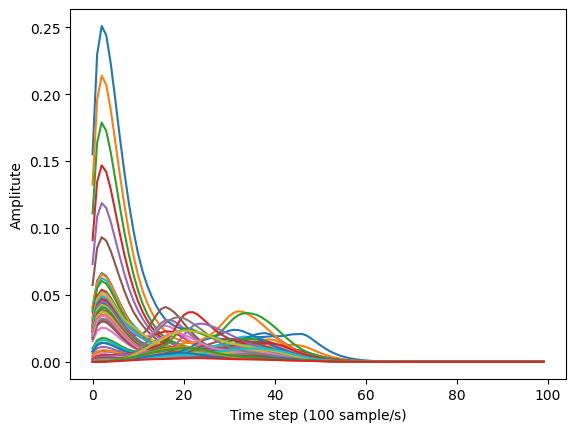

In [ ]:
# 波形表示1

plt.plot(x_train_lyon[0])
plt.xlabel('Time step (100 sample/s)')
plt.ylabel('Amplitute')
plt.show()

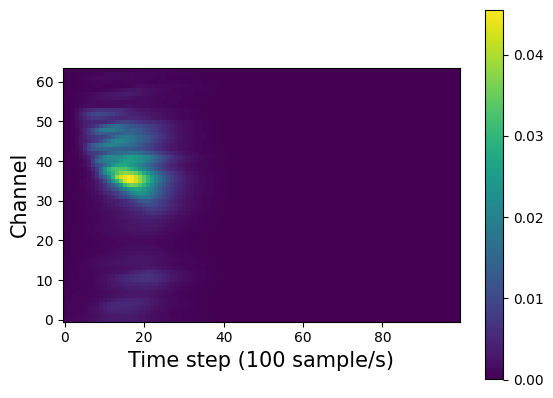

In [ ]:
# 波形表示2

plt.imshow(np.rollaxis(x_train_lyon[0], 1, 0), origin='lower')
plt.xlabel('Time step (100 sample/s)')
plt.ylabel('Channel')
plt.tick_params(labelsize=10)
plt.rcParams["font.size"] = 10
plt.colorbar()
plt.show()

# Multi-readout

In [ ]:
# xpをcupyにするとGPU対応

xp = np

In [ ]:
# レザバー（Echo state network）クラス

class Reservoir(object):
    def __init__(self, i_size, r_size, i_coef=1.0, r_coef=0.999, sparse=0.5, leak=0.5):
        # i_size: size of input
        # r_size: size of reservoir
        # i_coef: intensity of weight connection between input and reservoir
        # r_coef: intensity of weight connection in reservoir
        # sparse: sparseness of weight connection in reservoir (sparse=1.0 -> no connection)
        # leak_init: initial leak rate (leak=0.0 -> no update)

        self.w_i = xp.random.uniform(-i_coef, i_coef, (r_size, i_size)).astype(xp.float32)

        self.w_r = np.random.uniform(-1, 1, (r_size * r_size, )).astype(np.float32)
        self.w_r[0:int(r_size * r_size * sparse)] = 0
        np.random.shuffle(self.w_r)
        self.w_r = self.w_r.reshape(r_size, r_size)
        self.w_r = self.w_r / max(abs(np.linalg.eig(self.w_r)[0])) * r_coef
        self.w_r = xp.array(self.w_r)

        self.leak = leak


    # reset reservoir state
    def reset(self, batch):
        # batch: batch size of u, an argument of __call__()

        self.x = xp.zeros((batch, self.w_r.shape[0]), dtype=xp.float32)


    # update reservoir state
    # return: updated reservoir state (batch, r_size)
    def __call__(self, u):
        # u: input (batch, i_size)

        if not u.shape[0] == self.x.shape[0]:
            print('different batchsize')
            print('required:', self.x.shape[0])
            print('actual:', u.shape[0])

        self.x = xp.tanh((1 - self.leak) * self.x + self.leak * (u.dot(self.w_i.T) + self.x.dot(self.w_r.T)), dtype=xp.float32)

        return copy.deepcopy(self.x)

In [ ]:
# ridge regression
# return: weight connection between reservoir and output (o_size, r_size)
def ridge_regression(x, t, norm=1.0):
    # x: reservoir states (T, r_size)
    # t: target signals (T, o_size)
    # norm: coef of regularization term

    array = x.T.dot(x)
    array = array + norm * xp.eye(x.shape[1])
    array = xp.linalg.inv(array)
    array = array.dot(x.T)
    array = array.dot(t)

    return array.T

In [ ]:
# SOMクラス（2次元マップ）

class SOM2D(object):
    def __init__(self, map_size, in_size):
        # map_size (2, ): height and width of grid
        # in_size: dimension of input vector

        # w (m, m, i):
        self.w = np.random.rand(map_size[0], map_size[1], in_size)


    # get winner and neighborhood coef
    # return[0]: indices of winners (b, 2)
    # return[1]: neughborhood coefs (b, m, m)
    def __call__(self, x, var=1.0):
        # x (b, i): input vector (batch input is available)

        self.x_buf = x.reshape(-1, self.w.shape[2])
        # self.x_buf = x.reshape(-1, self.w.shape[2]).astype(np.float16)

        # winner take all
        sim = self.__l2norm_similarity(self.x_buf)
        self.c_buf = self.__winner_indices(sim)

        return self.c_buf, self.__gaussian(self.c_buf, var)


    # update w
    def update(self, lr, var=1.0):
        # Note: execute this function after __call__()

        # lr: learning rate
        # var: variance of Gaussian function

        # neighborhood function
        h = self.__gaussian(self.c_buf, var)

        # update
        dw = np.tensordot(h, self.x_buf, axes=(0, 0)) - self.w * np.sum(h, axis=0).reshape(self.w.shape[0], self.w.shape[1], 1)
        self.w += lr * dw / self.x_buf.shape[0]


    def __l2norm_similarity(self, x):
        batch = x.shape[0]
        map_h = self.w.shape[0]
        map_w = self.w.shape[1]
        l2norm = np.sum((x.reshape(batch, 1, 1, -1) - self.w.reshape(1, map_h, map_w, -1)) ** 2, axis=3)
        return -1 * l2norm


    def __winner_indices(self, x):
        x = x.reshape(x.shape[0], -1)
        c = np.argmax(x, axis=1)
        cy = c // self.w.shape[0]
        cx = c % self.w.shape[0]
        return np.append(cy.reshape(-1, 1), cx.reshape(-1, 1), axis=1)


    def __gaussian(self, c, var):
        indices = np.arange(c.shape[0]*self.w.shape[0]*self.w.shape[1]).reshape(c.shape[0], self.w.shape[0], self.w.shape[1])
        y = indices / self.w.shape[1] % self.w.shape[0]
        x = indices % self.w.shape[1]
        dy = np.abs(y - c[:,0].reshape(-1, 1, 1))
        dx = np.abs(x - c[:,1].reshape(-1, 1, 1))
        return np.exp(-(dy**2 + dx**2) / (var**2*2))

# 学習・テスト

In [ ]:
# Trainerクラス
# 学習・テスト・クロスバリデーションなど

class Trainer(object):
    def __init__(self):
        # Reservoir
        R_NODE = 100
        I_COEF = 30.0
        R_COEF = 0.999
        SPARSE = 0.5
        LEAK = 0.5
        self.res = Reservoir(i_size=64, r_size=R_NODE, i_coef=I_COEF, r_coef=R_COEF, sparse=SPARSE, leak=LEAK)

        # SOM
        # SOM_WIDTH * SOM_WIDTHがマルチリードアウトの数になる
        self.SOM_WIDTH = 8
        self.som = SOM2D((self.SOM_WIDTH, self.SOM_WIDTH), 100*64)


    # SOMの事前学習
    # data_trainのデータに対して
    # 学習率をSOM_LR_INI -> SOM_LR_FINに減衰させながら
    # ガウス関数の分散をSOM_VAR_INI -> SOM_VAR_FINに減衰させながら
    # SOMの参照ベクトルを更新
    def som_train(self, data_train):
        SOM_LR_INI = 0.1
        SOM_LR_FIN = 0.001
        SOM_VAR_INI = 3.0
        SOM_VAR_FIN = 0.1

        lr = SOM_LR_INI
        var = SOM_VAR_INI

        for x in data_train:
            x = x.reshape(1, -1)
            self.som(x)
            self.som.update(lr, var)

            lr += (SOM_LR_FIN - SOM_LR_INI) / data_train.shape[0]
            var += (SOM_VAR_FIN - SOM_VAR_INI) / data_train.shape[0]


    # SOMの参照ベクトルの可視化
    def som_vis(self):
        plt.rcParams["figure.figsize"] = (15, 15)
        for h in range(self.SOM_WIDTH):
            for w in range(self.SOM_WIDTH):
                plt.subplot(self.SOM_WIDTH, self.SOM_WIDTH, h * self.SOM_WIDTH + w + 1)
                plt.axis("off")
                # plt.plot(self.som.w[h][w].reshape(100, 64))
                plt.imshow(np.rollaxis(self.som.w[h][w].reshape(100, 64), 1, 0), origin='lower')


    # レザバーの学習
    def res_train(self, data_train, label_train):
        SOM_VAR2 = 1.0
        NORM = 0.1

        # reset reservoir
        self.res.reset(batch=data_train.shape[0])

        # (batch, time step, channel)となっているところを
        # (time step, batch, channel)に変換する
        x = xp.asarray(data_train)      # B, T, C
        x = xp.rollaxis(x, 1, 0)        # T, B, C

        # hs: internal states
        hs = []
        for u in x:
            h = self.res(u)
            hs.append(h)

        # (time step, batch, R_SIZE)となっているところを
        # (batch, time step, R_SIZE)に変換する
        hs = xp.asarray(hs)             # T, B, R
        hs = xp.rollaxis(hs, 1, 0)      # B, T, R

        # ts: targets signals
        ts = []
        for t in label_train:
            ohv = xp.zeros((x.shape[0], 10), dtype=xp.float32)
            ohv[:, t] = 1.0
            ts.append(ohv)

        # ns: neighbor coefs
        ns = []
        for x in data_train:
            x = x.reshape(1, -1)
            _, n = self.som(x, SOM_VAR2)
            ns.append(n.reshape(1, -1))

        # training data for each readout
        h_stock = [[] for i in range(self.SOM_WIDTH*self.SOM_WIDTH)]
        t_stock = [[] for i in range(self.SOM_WIDTH*self.SOM_WIDTH)]

        # SOMの近傍係数に応じて学習データをstock
        for h, t, n in zip(hs, ts, ns):
            for i, coef in enumerate(n.reshape(-1, )):
                h_cut = h[:int(coef * h.shape[0])]
                t_cut = t[:int(coef * t.shape[0])]

                h_stock[i].append(h_cut)
                t_stock[i].append(t_cut)

        # ridge regression
        self.ws = []
        for h, t in zip(h_stock, t_stock):
            h = xp.concatenate(h, axis=0)
            t = xp.concatenate(t, axis=0)
            w = ridge_regression(h, t, NORM)
            self.ws.append(w)


    # テスト
    def test(self, data_test, label_test):
        correct = 0.0
        count = 0.0

        wins = []
        for x, t in zip(data_test, label_test):
            win, _ = self.som(x.reshape(1, -1))
            wins.append(win[0][0] * self.SOM_WIDTH + win[0][1])

            self.res.reset(batch=1)

            x = xp.asarray(x)

            hs = []
            for u in x:
                h = self.res(u.reshape(1, -1))
                hs.append(h)
            hs = np.concatenate(hs, axis=0)

            y = hs.dot(self.ws[win[0][0] * self.SOM_WIDTH + win[0][1]].T)
            pred = np.argmax(np.mean(y, axis=0))

            if pred == t:
                correct += 1.0
            count += 1.0

        return correct / count, wins


    # クロスバリデーション
    def cross_validation(self, data_train, label_train):
        N_DIV = 5
        div_width = data_train.shape[0] // N_DIV

        accs = []
        for pattern in range(N_DIV):
            print('pattern:', pattern)

            tmp_data_train = []
            tmp_data_test = []
            tmp_label_train = []
            tmp_label_test = []

            for div in range(N_DIV):
                if div == pattern:
                    tmp_data_test.append(data_train[div*div_width:(div+1)*div_width])
                    tmp_label_test.append(label_train[div*div_width:(div+1)*div_width])
                else:
                    tmp_data_train.append(data_train[div*div_width:(div+1)*div_width])
                    tmp_label_train.append(label_train[div*div_width:(div+1)*div_width])

            tmp_data_train = np.concatenate(tmp_data_train, axis=0)
            tmp_data_test = np.concatenate(tmp_data_test, axis=0)
            tmp_label_train = np.concatenate(tmp_label_train, axis=0)
            tmp_label_test = np.concatenate(tmp_label_test, axis=0)

            print('\ttrain', tmp_data_train.shape)
            print('\ttest', tmp_data_test.shape)
            print('\ttrain', tmp_label_train.shape)
            print('\ttest', tmp_label_test.shape)

            print('\tsom_train')
            self.som_train(tmp_data_train)
            print('\tres_train')
            self.res_train(tmp_data_train, tmp_label_train)
            print('\ttest')
            acc, _ = self.test(tmp_data_test, tmp_label_test)
            print('\tacc:', acc)
            accs.append(acc)

        print('aveacc', np.mean(accs))

In [ ]:
t = Trainer()

In [ ]:
# クロスバリデーション→結果を見てレザバーのノード数などのパラメータ調整を繰り返す
t.cross_validation(x_train_lyon, t_digit_train)

pattern: 0
	train (2160, 100, 64)
	test (540, 100, 64)
	train (2160,)
	test (540,)
	som_train
	res_train
	test
	acc: 0.8203703703703704
pattern: 1
	train (2160, 100, 64)
	test (540, 100, 64)
	train (2160,)
	test (540,)
	som_train
	res_train
	test
	acc: 0.825925925925926
pattern: 2
	train (2160, 100, 64)
	test (540, 100, 64)
	train (2160,)
	test (540,)
	som_train
	res_train
	test
	acc: 0.8351851851851851
pattern: 3
	train (2160, 100, 64)
	test (540, 100, 64)
	train (2160,)
	test (540,)
	som_train
	res_train
	test
	acc: 0.7925925925925926
pattern: 4
	train (2160, 100, 64)
	test (540, 100, 64)
	train (2160,)
	test (540,)
	som_train
	res_train
	test
	acc: 0.8407407407407408
aveacc 0.8229629629629629


In [ ]:
t.som_train(x_train_lyon)

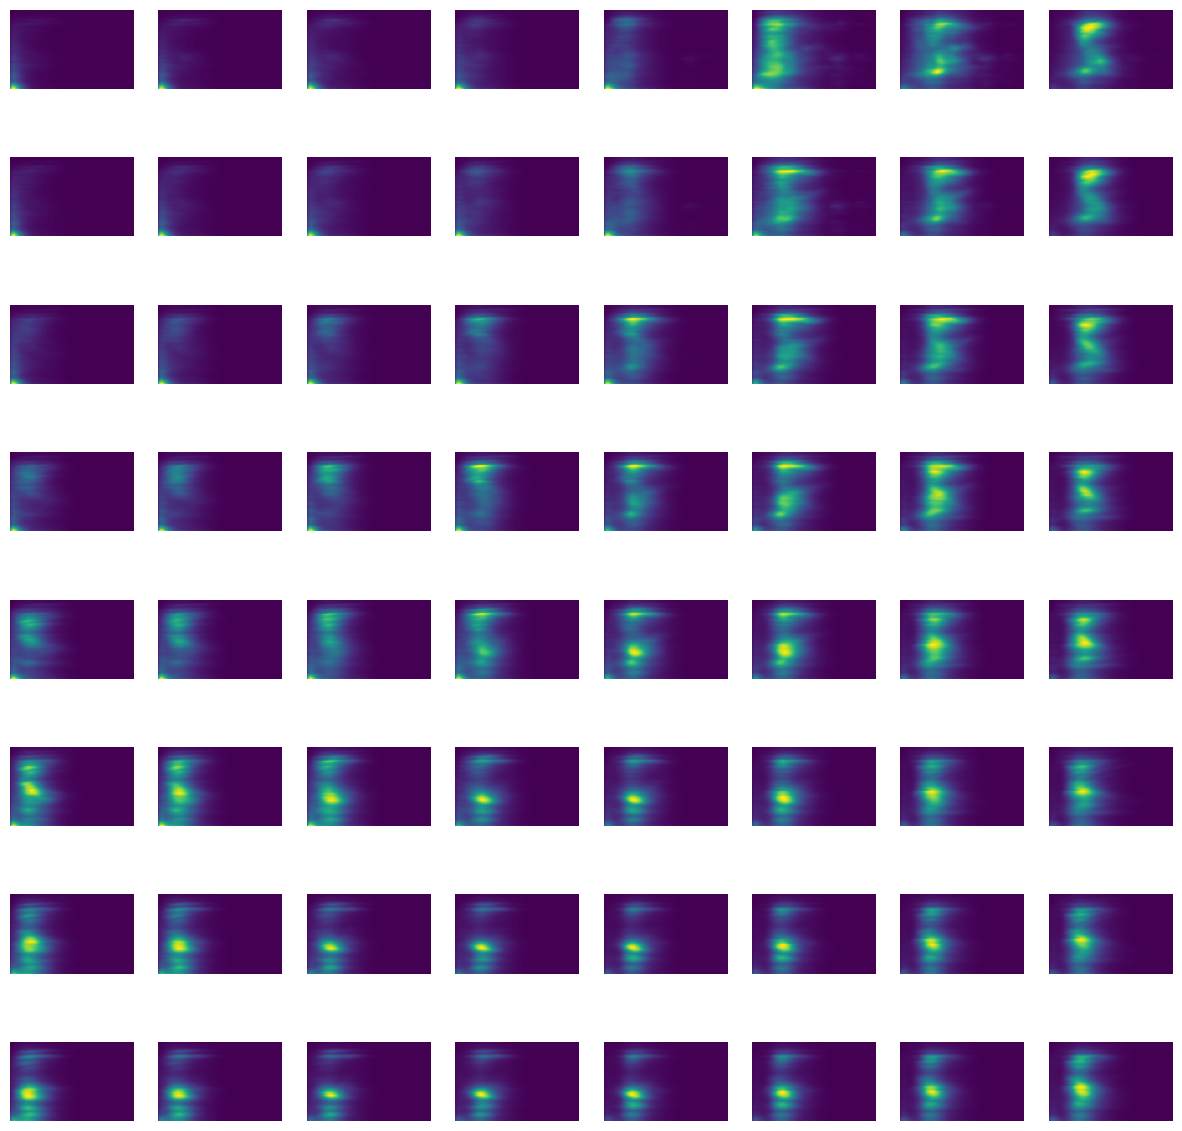

In [ ]:
t.som_vis()

In [ ]:
# digit classification

t.res_train(x_train_lyon, t_digit_train)
acc, _ = t.test(x_test_lyon, t_digit_test)
print(acc)

0.8266666666666667


In [ ]:
# person classification

t.res_train(x_train_lyon, t_person_train)
acc, _ = t.test(x_test_lyon, t_person_test)
print(acc)

0.9066666666666666
